<a href="https://colab.research.google.com/github/CoDeRror555/Analitic_projects-/blob/main/wiki_voted_analitics_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# запросы в интернет
import urllib
import requests

# работа с таблицами
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# кластеризация 
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Исследовательский анализ пользователей Wikipedia. Особенности электорального поведения во время выборов администраторов и бюрократов

# Основные цели:
* **Выявить закономерности и особенности в активности пользователей**
* **Провести сегментацию пользователей**
* **Провести анализ электорального поведения во время выборов администраторов и бюрократов**
* **Определить оптимальное место для кофейни в стиле "Central Perk"**
 ## Решённые задачи:
 - [x] **Проведена предобработка данных**
 - [x] **Выявлены особенности в активности пользователей**
 - [x] **Введены новые метрики описывающие пользователей**
 - [x] **Составлен профиль пользователя**
 - [x] **Проведена сегментация пользователей, принимавших участие в выборах**
 - [x] **Проведен анализ электорального поведения во время выборов**
 - [x] **Определены аномалии во время выборов**
 - [x] **Определен круг пользователей, проявивших аномальное электоральное поведение**
### Используемые инструменты:
*python, numpy, pandas, matplotlib, seaborn, sklearn*
* **



In [2]:
# загрузим данные
# local case
try:
    df_votes = pd.read_excel('F:\\wiki_votes\\wiki_arbcom.xlsx',index_col=0)
    df_users = pd.read_excel('F:\\wiki_votes\\wiki_userstat.xlsx',index_col=0)
# global case
except:
    df_votes = pd.read_excel('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/FeksN15lDklabw',index_col=0)
    df_users = pd.read_excel('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/BjUeD6qgoAza8A',index_col=0)

In [3]:
# функция для получения иныфо о данных
def df_info(df:pd.DataFrame) -> None:
    '''Распечатывает информацию о датафрейме'''

    # Выводим инфо
    df.info()

    # Сохраняем пропуски
    df_nans = np.trim_zeros(df_users.isna().mean().sort_values())

    if len(df_nans > 0):
        print('\nNA:',end='')
        display(df_nans)

    # Пример данных
    display(df.dropna().sample().T)

    for col in df.columns:
        if df[col].nunique() < 20:
            display(df[col].value_counts())

# Анализ таблицы с данными о пользователях

In [4]:
print(f"Количество полных дубликатов: {df_users.duplicated().sum()}")

Количество полных дубликатов: 0


In [5]:
# отобразим основную информацию
df_info(df_users)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664 entries, 0 to 663
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User               664 non-null    object
 1   Groups             53 non-null     object
 2   EditsTotal         664 non-null    int64 
 3   EditsEdits         664 non-null    int64 
 4   EditsArticles      664 non-null    int64 
 5   CreationsPages     664 non-null    int64 
 6   CreationsArticles  664 non-null    int64 
 7   TextsVolume        664 non-null    int64 
 8   Logs               664 non-null    int64 
 9   Months             664 non-null    int64 
 10  H/d                664 non-null    object
dtypes: int64(8), object(3)
memory usage: 62.2+ KB

NA:

Groups    0.920181
dtype: float64

,421
User,Sigwald
Groups,S
EditsTotal,144000
EditsEdits,61000
EditsArticles,38000
CreationsPages,2021
CreationsArticles,240
TextsVolume,64000000
Logs,84000
Months,166


S      43
BS      3
COS     3
I       2
IS      1
OS      1
Name: Groups, dtype: int64

* **Мы видим проблемы с названиями колонок, большое количество пропусков в колонке с группами, неверные формат в колонке со средним временем у юзера. Добавим функции для корректировок**

In [6]:
# добавляет аннотации к барам
def add_value_labels(ax,bar_or_barh, space=4,fmt="{:.0f}"):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
        frm: format annotaitions
        bar_or_barh: chose bar or barh pyplot
    """
    if bar_or_barh == 'bar':
        # For each bar: Place a label
        heights = [rect.get_height() for rect in ax.patches]
        for rect in ax.patches:
            # Get X and Y placement of label from rect.
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2
            
            
            if y_value > 0:
                va = 'bottom'
                label = fmt.format(y_value)
                # Create annotation
                if y_value > max(heights)/2:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, y_value/2),         # Place label at end of the bar
                        xytext=(0, space),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)                      # Vertically align label differently for
                else:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, rect.get_y()+rect.get_height()),         # Place label at end of the bar
                        xytext=(0, space),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,size = 10)
            elif y_value == 0:
                va = 'top'
                label = fmt.format(y_value)
                ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, rect.get_y()+rect.get_height()),         # Place label at end of the bar
                        xytext=(0, space),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va='center',
                        rotation=90,size = 10)
                
            else:
            
                # Invert space to place label belo
                # Vertically align label at top
                va = 'top'
                # Use Y value as label and format number with one decimal place
                label = fmt.format(y_value)
                    # Create annotation
                if y_value < min(heights)/2:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, y_value/2),         # Place label at end of the bar
                        xytext=(0, 0),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)                      # Vertically align label differently for
                                                    # positive and negative values.
                else:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, rect.get_y()+rect.get_height()),         # Place label at end of the bar
                        xytext=(0, 0),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,size = 10)                      # Vertically align label differently for
                                                # positive and negative values.
    elif bar_or_barh == 'barh':
        
        # Получаем ширины столбиков
        widths = [rect.get_width() for rect in ax.patches]
        heights = [rect.get_height() for rect in ax.patches]
        # Добавляем аннотации на каждый столбик     
        for i, rect in enumerate(ax.patches):
            # Перемещаем аннотацию внутрь столбика         
            if widths[i] < 0:
                if widths[i] < min(widths)/2:
                    space *= -1
                    ax.annotate(fmt.format(widths[i]), xy=(widths[i]/2, rect.get_y() + rect.get_height()/2),\
                                xytext=(0, 0), textcoords="offset points", ha='center', va='center',color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)
                else:
                    space *= -1
                    ax.annotate(fmt.format(widths[i]), xy=(rect.get_x() + rect.get_width(),rect.get_y() + rect.get_height() / 2),\
                            xytext=(space-3, 0), textcoords="offset points", ha='right', va='center',size = 10)
            
            elif widths[i] == 0:
                ax.annotate(fmt.format(widths[i]), xy=(widths[i],rect.get_y() + rect.get_height()/2),\
                            xytext=(0, 0), textcoords="offset points", ha='center', va='center',size = 10)
                
            elif widths[i] > 0:
                if widths[i] > max(widths)/2:
                    ax.annotate(fmt.format(widths[i]), xy=(widths[i]/2, rect.get_y() + rect.get_height()/2),\
                                xytext=(0, 0), textcoords="offset points", ha='center', va='center',color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)

                else:
                    ax.annotate(fmt.format(widths[i]), xy=(rect.get_x() + rect.get_width(),rect.get_y() + rect.get_height() / 2),\
                            xytext=(space, 0), textcoords="offset points", ha='left', va='center',size = 10)
    else:
        return(print("inter name 'bar or bash'"))        

In [7]:
# понижает регистр
def corrected_columns(list_col):
    try:
        columns = []
        for i in list_col:
            columns.append(i.lower().strip().replace(' ','_'))
        return(columns)
    except: print('err')


In [8]:
# переводит строковый формат в количество минут для нашего случая
def hour_to_minute(s):
    try:
        if ' h' in s:
            s1 = s.split(' h')
            if s1[1] == '':
                t1= int(s1[0])*60
                return t1
            else:
                t1 = (int(s1[0])*60)+int(s1[1])
                return t1
        elif ' m' in s:
                s2 = s.split(' m')
                return int(s2[0])
        else:
            return int(s)
    except: return s


In [9]:
# приведем названия в порядок
df_users.columns = corrected_columns(df_users.columns)

In [10]:
# исправим параметры активности
df_users['min/day'] = df_users['h/d'].apply(hour_to_minute)

In [11]:
# проверим
df_users.head()

,user,groups,editstotal,editsedits,editsarticles,creationspages,creationsarticles,textsvolume,logs,months,h/d,min/day
0,-PhoeniX-,NaN,9400,8600,6000,768,141,7600000,713,182,20 m,20
1,1.b2-b4,NaN,6700,6600,5700,352,150,2800000,123,30,2 h 10,130
2,1677venzel gottorpskij,NaN,11000,9100,6400,133,23,2200000,1900,71,35 m,35
3,1Goldberg2,NaN,44000,39000,36000,3550,2203,7400000,5600,54,1 h 40,100
4,22mirbymirbymirby,NaN,1000,988,738,27,8,833000,44,14,1 h,60


In [12]:
print(f'Всего пользователей: {len(df_users.user.unique())}')
print(f"Члены арбитражного камитета: {len(df_users.loc[~df_users['groups'].isna()])}")

Всего пользователей: 664
Члены арбитражного камитета: 53


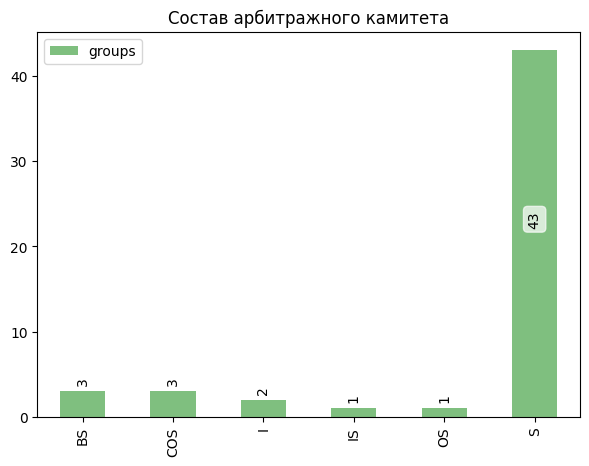

In [13]:
# посмотрим на состав арбитражного камитета
ax = df_users.groupby(by='groups')['groups'].count().plot(kind ='bar', color = 'green', alpha=0.5,figsize=(7,5))
add_value_labels(ax,'bar', space=4,fmt="{:.0f}")
plt.title('Состав арбитражного камитета')
plt.ylabel('')
plt.xlabel('')
plt.legend()
plt.show()

* **Менее 10 процентов из представленных пользователей члены арбитражного комитета, причем основная их часть это администраторы. Всего пользователей: 664**

In [14]:
# добавим маркер принадлежности 
df_users['is_arb'] = ~df_users['groups'].isna()

## Разберем столбцы  'editstotal','editsedits','editsarticles'

*Очевидно что данные поля содержат подобную информацию о пользователе, которая может пересекаться и имееть сильную корреляцию. Построим парный график*

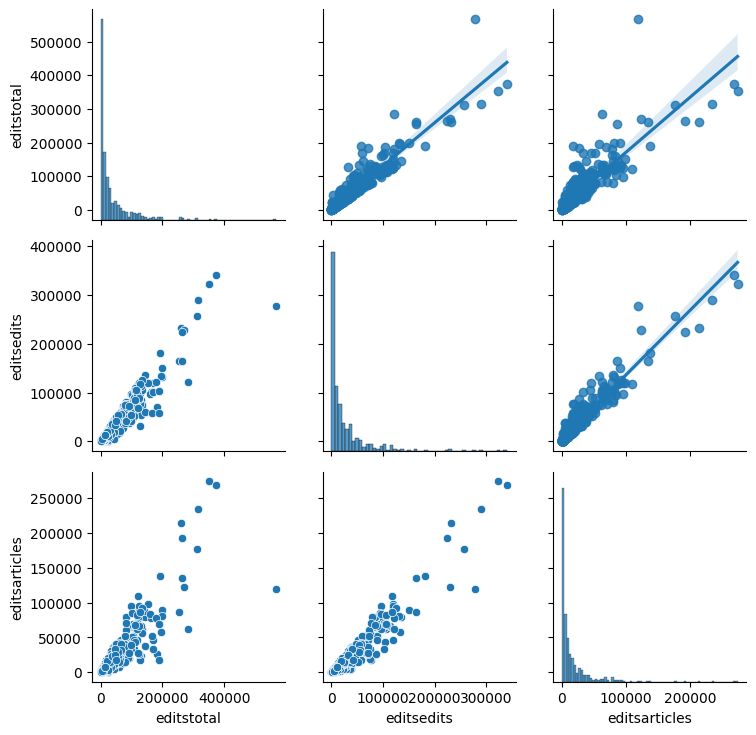

count       664.00
mean      34401.10
std       54969.38
min         562.00
25%        3375.00
50%       13000.00
75%       42000.00
max      568000.00
Name: editstotal, dtype: float64

count       664.00
mean      25640.65
std       40674.32
min         494.00
25%        2875.00
50%       10000.00
75%       32000.00
max      340000.00
Name: editsedits, dtype: float64

count       664.00
mean      16510.59
std       29506.49
min         248.00
25%        1900.00
50%        5700.00
75%       18000.00
max      274000.00
Name: editsarticles, dtype: float64

In [15]:
# посмотрим на распределения в данных полях
g = sns.PairGrid(df_users[['editstotal','editsedits','editsarticles']], height=2.5)
g.map_upper(sns.regplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
plt.show();

# посмотрим на значения
for i in df_users[['editstotal','editsedits','editsarticles']].columns:
    print(i)
    display(df_users[i].describe(include='all').round(2))
    print('****************************')

* **Как и ожидалось, значения в данных полях имеют тенденцию на уменьшение значений от первого к последнему и очень сильно коррелируют. Логично предположить, что это подобные множества и описывать пользователя не целесообразно по всем 3 отдельно. Средние медианные величины по данным показателям составляют 13000, 10000 и 5000 соответственно**

## Разберем поля 'editsarticles' и 'creationspages'

*Данные имеют схожие ожидания, что и выше. Проверим уровень корреляции сразу*

In [16]:
df_users['editsarticles'].corr(df_users['creationspages'].round())

editstotal
****************************
editsedits
****************************
editsarticles
****************************


0.7000179974251592

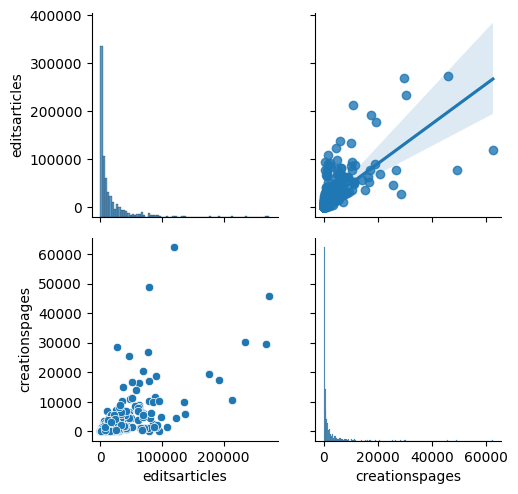

editsarticles


count       664.00
mean      16510.59
std       29506.49
min         248.00
25%        1900.00
50%        5700.00
75%       18000.00
max      274000.00
Name: editsarticles, dtype: float64

****************************
creationspages


count      664.00
mean      1870.71
std       4985.00
min          0.00
25%         83.50
50%        367.00
75%       1430.50
max      62470.00
Name: creationspages, dtype: float64

****************************


In [17]:
# посмотрим на распределения в данных полях
g = sns.PairGrid(df_users[['editsarticles','creationspages']], height=2.5)
g.map_upper(sns.regplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
plt.show();

# посмотрим на значения
for i in df_users[['editsarticles','creationspages']].columns:
    print(i)
    display(df_users[i].describe(include='all').round(2))
    print('****************************')

* **По данным полям мы видим похожую ситуацию, хотя и уровень корреляции не столь значительный. Средние медианные значения составляют 5700 и 367 соответственно.**

## Разберем столбцы 'min/day', 'months', 'textsvolume' и 'logs'

*Здесь два временных параметра явно будут сильно коррелировать с объемом набранного текста в байтах, проверим*

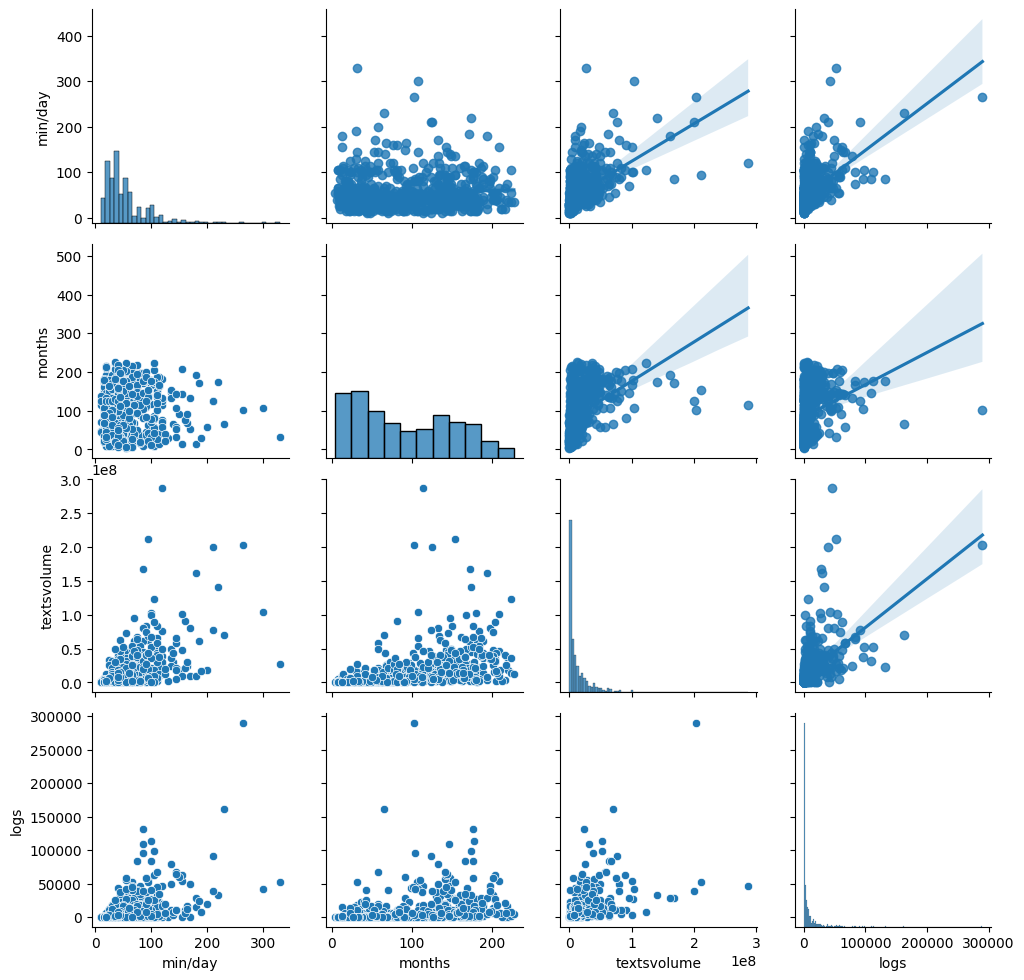

min/day


count    664.00
mean      54.67
std       39.66
min       10.00
25%       30.00
50%       40.00
75%       65.00
max      330.00
Name: min/day, dtype: float64

****************************
months


count    664.00
mean      91.05
std       60.40
min        4.00
25%       36.00
50%       78.50
75%      142.00
max      227.00
Name: months, dtype: float64

****************************
textsvolume


count    6.640000e+02
mean     1.545231e+07
std      2.686163e+07
min      6.700000e+04
25%      1.600000e+06
50%      5.650000e+06
75%      1.825000e+07
max      2.870000e+08
Name: textsvolume, dtype: float64

****************************
logs


count       664.00
mean       8755.00
std       20495.77
min           1.00
25%         247.00
50%        1600.00
75%        7250.00
max      290000.00
Name: logs, dtype: float64

****************************


In [18]:
# посмотрим на распределения в данных полях
g = sns.PairGrid(df_users[['min/day','months','textsvolume','logs']], height=2.5)
g.map_upper(sns.regplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
plt.show();

# посмотрим на значения
for i in df_users[['min/day','months','textsvolume','logs']].columns:
    print(i)
    display(df_users[i].describe([.25, .5, .75],include='all').round(2))
    print('****************************')

* **Мы видим увеличение добавленного текста и числа логов с увеличением срока жизни пользователя и среднего количества потраченного времени, причем связь среднего потраченного времени и объёма текста более выраженная. Явной связи в увеличении среднего времени и срока жизни нет. Средние медианное значение для полей 'min/day','months','textsvolume' и logs равно 40 минут, 78 месяцев, 5.650000000000 байт и 1600 записей в логах соответственно. В полях не отражающих временные показатели значения имеют ассиметричное распределение значений с далекими выбросами**

## Обоснование введения новых метрик

**На основе проведенного анализа данных мы можем сделать вывод, что для более точного описания активности пользователя нам будет целесообразно ввести новые показатели, которые свяжут поля с сильной корреляцией и логической ее связью между собой. Далее, для более точной сегментации наших пользователей, ввиду будущего наличия у них качественных поведенческих признаков, для количественных параметров мы выберем принцип бинарной сегментации, которое будет делить наше множество на 2 равные группы на основе медианного показателя этого параметра, таким образом мы уровняем вес этих показателей**

 ### Введем новые параметры product_min, act_min, ef_edit, is_artictl, is_new, is_editor

**'is_editor' - основная часть активности это правки**

In [19]:
df_users['is_editor'] = df_users['logs'] > 1600

**'is_new' - делит на новых и старых пользователей**

In [20]:
# введем новый параметр, который характеризует новых и старых
df_users['is_new'] = df_users['months']<36

**'act_min' - отражает активность пользователя выраженную в том, какой объём правок в мегабайтах он добавляет в единицу времени каждый день**

In [21]:
df_users['act_min'] = (df_users['textsvolume']/df_users['min/day'])/1048576

**'product_min' - продуктивность отражает какое количество правок он делает в единицу времени**

In [22]:
df_users['product_min'] =  df_users['editstotal']/df_users['min/day']

**'ef_edit' - эффективность отражает отношение принятых ко всем правкам**

In [23]:
df_users['ef_edit'] = df_users['editsedits']/df_users['editstotal']

**'is_artictl' - отражает разность между общей и энциклопедической активностью**

In [24]:
df_users['is_artictl'] = (df_users['editsedits'] + df_users['creationspages'])\
                          -(df_users['editsarticles'] + df_users['creationsarticles'])
df_users['is_artictl'].describe()

count       664.000000
mean      10520.926205
std       17867.567829
min           0.000000
25%         834.000000
50%        3855.500000
75%       11890.250000
max      221430.000000
Name: is_artictl, dtype: float64

In [25]:
# добавим флаг
df_users['is_artictl'] = df_users['is_artictl']< 3855.500000

## Проведем анализ взаимосвязей новых метрик

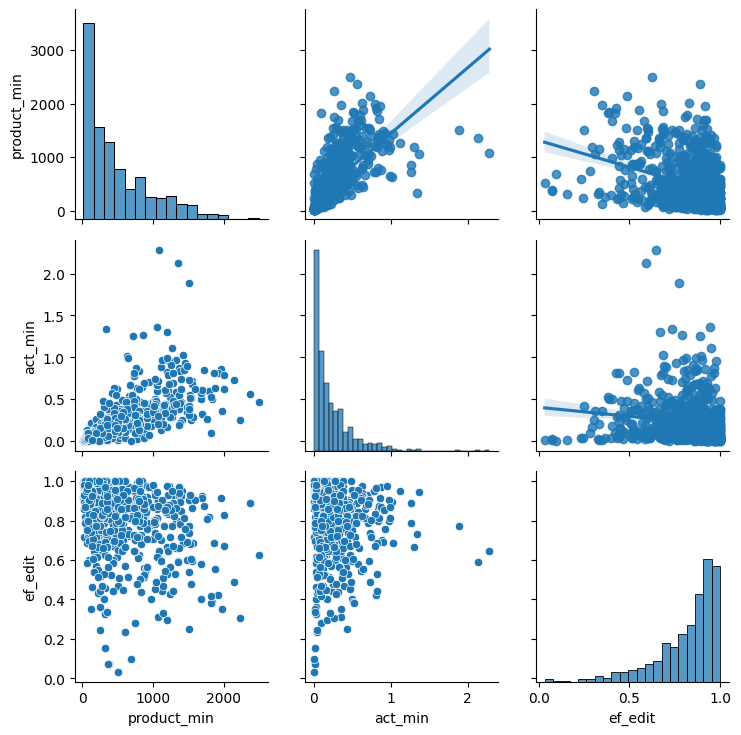

product_min


count     664.0000
mean      497.6626
std       485.1975
min        14.1400
25%       107.4359
50%       331.6667
75%       766.6667
max      2495.2381
Name: product_min, dtype: float64

****************************
act_min


count    664.0000
mean       0.2288
std        0.2730
min        0.0032
25%        0.0420
50%        0.1335
75%        0.3206
max        2.2809
Name: act_min, dtype: float64

****************************
ef_edit


count    664.0000
mean       0.8182
std        0.1729
min        0.0324
25%        0.7389
50%        0.8750
75%        0.9412
max        1.0000
Name: ef_edit, dtype: float64

****************************


In [26]:
# посмотрим на распределения в данных полях
g = sns.PairGrid(df_users[['product_min','act_min','ef_edit']], height=2.5)
g.map_upper(sns.regplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
plt.show();

# посмотрим на значения
for i in df_users[['product_min','act_min','ef_edit']].columns:
    print(i)
    display(df_users[i].describe([.25, .5, .75],include='all').round(4))
    print('****************************')

* **Новые метрики также коррелируют, но в меньшей степени и с разной направленностью. Добавим новые пороговые значения для будущих профилей**

In [27]:
# добавим новые значения 
df_users['is_ef'] = df_users.ef_edit > 0.8750
df_users['is_act'] = df_users.act_min >  0.1335
df_users['is_product'] = df_users.product_min > 331.6667

## Сравним общую выборку со срезом новых пользователей

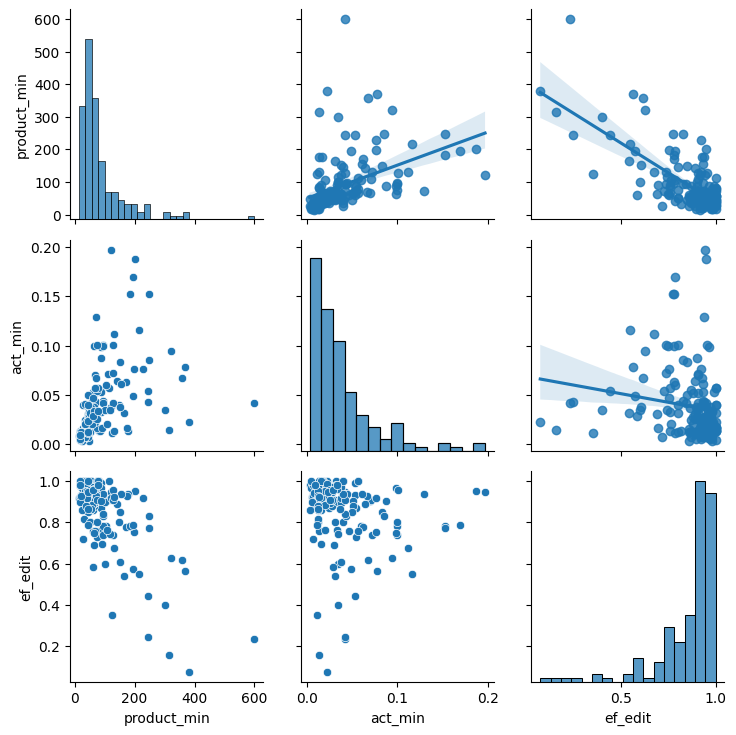

product_min


count    161.000000
mean      89.043590
std       83.505951
min       14.140000
25%       40.000000
50%       60.000000
75%      100.000000
max      600.000000
Name: product_min, dtype: float64

****************************
act_min


count    161.000000
mean       0.038703
std        0.035857
min        0.003195
25%        0.013775
50%        0.027771
75%        0.049591
max        0.197093
Name: act_min, dtype: float64

****************************
ef_edit


count    161.000000
mean       0.857538
std        0.166248
min        0.073684
25%        0.800000
50%        0.917963
75%        0.953125
max        1.000000
Name: ef_edit, dtype: float64

****************************


In [28]:
# посмотрим на распределения в данных полях
g = sns.PairGrid(df_users.loc[df_users['is_new']==True][['product_min','act_min','ef_edit']], height=2.5)
g.map_upper(sns.regplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
plt.show();

# посмотрим на значения
for i in df_users[['product_min','act_min','ef_edit']].columns:
    print(i)
    display(df_users.loc[df_users['is_new']==True][['product_min','act_min','ef_edit']][i].describe([.25, .5, .75],include='all').round(6))
    print('****************************')

* **Можно заметить разную степень корреляции в данных группах. Сравним опытных и новых пользователей, посчитаем корреляцию**

In [29]:
print(f"Эффективность и продуктивность опытных пользователей: {df_users.loc[df_users['is_new']==False].product_min.corr(df_users.ef_edit)}")
print(f"Эффективность и продуктивность новых пользователей: {df_users.loc[df_users['is_new']==True].product_min.corr(df_users.ef_edit)}")
print('***************************************')
print(f"Эффективность и активность опытных пользователей: {df_users.loc[df_users['is_new']==False].act_min.corr(df_users.ef_edit)}")
print(f"Эффективность и активность новых пользователей: {df_users.loc[df_users['is_new']==True].act_min.corr(df_users.ef_edit)}")
print('***************************************')
print(f"Продуктивность и активность опытных пользователей: {df_users.loc[df_users['is_new']==False].act_min.corr(df_users.product_min)}")
print(f"Продуктивность и активность новых пользователей: {df_users.loc[df_users['is_new']==True].act_min.corr(df_users.product_min)}")

Эффективность и продуктивность опытных пользователей: -0.3466833946343884
Эффективность и продуктивность новых пользователей: -0.7252871426656005
***************************************
Эффективность и активность опытных пользователей: -0.10083710647738865
Эффективность и активность новых пользователей: -0.16208664179374427
***************************************
Продуктивность и активность опытных пользователей: 0.624931468765065
Продуктивность и активность новых пользователей: 0.43617455341616135


* **По результатам можно заметить существенную разницу в показателях по двум срезам. Мы видим отрицательную корреляцию между показателями эффективности и продуктивности в обеих группах, однако у опытных пользователей он в 2 раза ниже, что можно объяснить более качественной работой вторых, но в целом чем больше правок делает пользователь тем меньшее количество их принимается. Подобную тенденцию мы можем заметить и в связи эффективности с активностью — то есть чем больше объем правок в мегабайтах тем меньшее их число принимают. Продуктивность и активность имеют положительную корреляцию, что в принципе логично - чем больше количество правок тем большее объем текста, но опытные пользователи опять впереди**

# Вывод по итогам предобработки и анализа полей таблицы с данными пользователей:
* **Менее 10 процентов из представленных пользователей члены арбитражного комитета, причем основная их часть это администраторы. Всего пользователей: 664**
* **Значения в полях 'editstotal','editsedits','editsarticles' имеют тенденцию на уменьшение значений от первого к последнему и очень сильно коррелируют. Средние медианные величины по данным показателям составляют 13000, 10000 и 5000 соответственно**
* **По полям 'editsarticles','creationspages' мы видим похожую ситуацию, хотя и уровень корреляции не столь значительный. Средние медианные значения составляют 5700 и 367 соответственно.**
* **Мы видим увеличение добавленного текста и числа логов с увеличением срока жизни пользователя и среднего количества потраченного времени, причем связь среднего потраченного времени и объёма текста более выраженная. Явной связи в увеличении среднего времени и срока жизни нет. Средние медианное значение для полей 'min/day','months','textsvolume' и logs равно 40 минут, 78 месяцев, 5.650000000000 байт и 1600 записей в логах соответственно. В полях не отражающих временные показатели значения имеют ассиметричное распределение значений с далекими выбросами**
* **Новые метрики также коррелируют, но в меньшей степени и с разной направленностью. Добавим новые пороговые значения для будущих профилей**
* **Можно заметить существенную разницу в показателях по двум срезам. Мы видим отрицательную корреляцию между показателями эффективности и продуктивности в обеих группах, однако у опытных пользователей он в 2 раза ниже, что можно объяснить более качественной работой вторых, но в целом чем больше правок делает пользователь тем меньшее количество их принимается. Подобную тенденцию мы можем заметить и в связи эффективности с активностью — то есть чем больше объем правок в мегабайтах тем меньшее их число принимают. Продуктивность и активность имеют положительную корреляцию, что в принципе логично — чем больше количество правок тем большее объем текста, но опытные пользователи опять впереди**
* **Во всех полях с количественными значениями значения распределены неравномерно и имеют большие выбросы**

# Анализ таблицы с данными о голосовании

In [30]:
print(f"Количество полных дубликатов: {df_votes.duplicated().sum()}")

Количество полных дубликатов: 0


In [31]:
# посмотрим на основную информацию
df_info(df_votes)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16857 entries, 0 to 2738
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   voter      16857 non-null  object        
 1   can_vote   16857 non-null  bool          
 2   time       16857 non-null  datetime64[ns]
 3   candidate  16857 non-null  object        
 4   n          16857 non-null  int64         
 5   vote       16857 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(2)
memory usage: 806.6+ KB

NA:

groups    0.920181
dtype: float64

,2468
voter,LokkLamora
can_vote,True
time,2020-07-30 08:10:00
candidate,Mihail Lavrov
n,30
vote,1


True     16116
False      741
Name: can_vote, dtype: int64

32    4170
33    3374
34    3303
30    2041
31    2041
35    1928
Name: n, dtype: int64

 1    9811
-1    7046
Name: vote, dtype: int64

* **По общей информации видно, что пропусков в таблице нет, незасчитанных голосов 741 из 16857, электоральная активность неравномерна — самая высокая на 32 выборах самая низкая на 35**

In [32]:
# усечем дату до дней и часов - пригодится в дальнейшем 
df_votes['day'] = df_votes.time.astype(object).astype('datetime64[D]')
df_votes['hour'] = df_votes.time.astype(object).astype('datetime64[h]')
df_votes['day'].head() 

0   2020-07-30
1   2020-07-30
2   2020-07-30
3   2020-07-30
4   2020-08-02
Name: day, dtype: datetime64[ns]

In [33]:
df_votes.head()

,voter,can_vote,time,candidate,n,vote,day,hour
0,X0stark69,True,2020-07-30 11:55:00,Adamant.pwn,30,1,2020-07-30,2020-07-30 11:00:00
1,Mike like0708,True,2020-07-30 09:32:00,Adamant.pwn,30,-1,2020-07-30,2020-07-30 09:00:00
2,Brateevsky,True,2020-07-30 14:43:00,Adamant.pwn,30,1,2020-07-30,2020-07-30 14:00:00
3,Forgottenous,True,2020-07-30 08:09:00,Adamant.pwn,30,1,2020-07-30,2020-07-30 08:00:00
4,Swarrel,True,2020-08-02 14:57:00,Adamant.pwn,30,1,2020-08-02,2020-08-02 14:00:00


* **Необходимо добавить информацию об активности пользователей к таблице с данными по голосованию, чтобы дополнить их профили информацией об ох электоральном поведении и провести полный анализ.**

In [34]:
# проверка
df_votes.vote.unique()

array([ 1, -1])

In [35]:
# добавим поле для объединения 
df_users['user_name'] = df_users['user'] 
df_votes['user_name'] = df_votes['voter']

In [36]:
# объеденим таблицы
df = df_votes.merge(df_users,how='left',on='user_name')
df.head()


,voter,can_vote,time,candidate,n,vote,day,hour,user_name,user,...,is_arb,is_editor,is_new,act_min,product_min,ef_edit,is_artictl,is_ef,is_act,is_product
0,X0stark69,True,2020-07-30 11:55:00,Adamant.pwn,30,1,2020-07-30,2020-07-30 11:00:00,X0stark69,X0stark69,...,False,True,False,0.209808,810.000000,0.506173,False,False,True,True
1,Mike like0708,True,2020-07-30 09:32:00,Adamant.pwn,30,-1,2020-07-30,2020-07-30 09:00:00,Mike like0708,Mike like0708,...,False,True,False,0.129700,316.000000,0.455696,True,False,False,False
2,Brateevsky,True,2020-07-30 14:43:00,Adamant.pwn,30,1,2020-07-30,2020-07-30 14:00:00,Brateevsky,Brateevsky,...,False,True,False,0.362396,1140.000000,0.508772,False,False,True,True
3,Forgottenous,True,2020-07-30 08:09:00,Adamant.pwn,30,1,2020-07-30,2020-07-30 08:00:00,Forgottenous,Forgottenous,...,False,True,False,0.222524,128.333333,0.740260,True,False,True,False
4,Swarrel,True,2020-08-02 14:57:00,Adamant.pwn,30,1,2020-08-02,2020-08-02 14:00:00,Swarrel,Swarrel,...,False,True,False,0.135634,400.000000,0.522222,False,False,True,True


In [37]:
# уберем плохие голоса
df = df.loc[df['can_vote']==True]


 **Зададим функцию для расчета всех необходимых для анализа параметров**
  * *Помимо прочего в функции происходит вычисление 4 показателей электорального поведения, которые записываются в профиль голосующего*
    * **conf -  является ли конформистом**
    * **is_lday - голосовал в последний день**
    * **is_definded - все голоса в один день**
    * **all_voter - отдал голоса за всех кандидатов**


In [38]:
def voters_itog_wiki(n, df):
    ''' принимает 2 параметра - номер выборов и датафрейм с информацией о голосовании
         
         на выходе получаем: vote_history - таблица с изменением результата голосования по дням
                             k – результат со списком кандидатов и процентов голосов за
                             winners - список победителей
                             v - сумма голосов по дням голосования
                             voters - список голосовавших на выборах
                             losers - список проигравших кандидатов
                             voters_profile - профили пользователей
                             vot_cand - таблица голосования 
    '''
    df_votes = df.loc[df['n']==n]
    
    
    # Create count of votes table
    cv = df_votes.loc[df_votes['n']==n].groupby(by=['day','candidate'])['vote'].count().reset_index()
    cv = cv.pivot_table(index = 'candidate', columns = 'day',values = 'vote').drop_duplicates().cumsum(axis = 1).fillna(0)
    
    # create sum positive votes table
    d = df_votes.loc[(df_votes['n']==n)&(df_votes['vote']>=0)].groupby(by=['day','candidate'])['vote'].sum().reset_index()
    d = d.pivot_table(index = 'candidate', columns = 'day',values = 'vote').drop_duplicates().cumsum(axis = 1).fillna(0)
    
    # create final table 
    vote_history = d/cv
    vote_history = vote_history.fillna(0)

    # result
    k = vote_history[vote_history.columns[-1]]
    
    # winners 
    winners = vote_history[vote_history.columns[-1]][vote_history[vote_history.columns[-1]]>0.66666]
    
    
    # losers
    losers = vote_history[vote_history.columns[-1]][vote_history[vote_history.columns[-1]]<=0.66666]


    # active vote
    v = df_votes.loc[(df_votes['n']==n)].groupby(by=['day'])['vote'].sum().fillna(0)
    #########################################################
    
    # add confirm mark
    df_ = df_votes.loc[(df_votes['n']==n)]
    df_['conf'] = (df_votes.loc[(df_votes['n']==n)]['candidate'].isin(list(winners.index)) & (df_votes.loc[(df_votes['n']==n)]['vote'] == 1))\
    == (df_votes.loc[(df_votes['n']==n)]['candidate'].isin(list(losers.index)) & (df_votes.loc[(df_votes['n']==n)]['vote'] == -1))

    df_ = df_.groupby(by='voter')['conf'].agg(['nunique'])

    df_ = df_.replace({2:False,1:True})
    df_.columns = ['conf']
    
    # add last day voter mark
    s = pd.DataFrame()
    s['is_lday'] = df_votes.loc[(df_votes['n']==n)].groupby(by=['voter'])['day'].max() == df_votes.loc[(df_votes['n']==n)]['day'].max()
    s = s['is_lday']
    
    # add more segments
    tmp =df_votes.loc[(df_votes['n']==n)].groupby(by=['voter'])['day'].agg(['nunique','count'])
    tmp['is_definded'] = tmp['nunique'] == 1
    tmp['all_voter'] = tmp['count'] == len(k)
    tmp = tmp[['is_definded','all_voter']]
    
    # create table with profile voters
    voters_profile = df_votes[['voter','is_arb','is_new','is_ef', 'is_act', 'is_product','is_artictl','is_editor']]
    voters_profile = voters_profile.drop_duplicates()
    voters_profile.index = voters_profile['voter']
    voters_profile = voters_profile.drop('voter',axis = 1)
    
    
    # add more param
    voters_profile = voters_profile.join(tmp)
    voters_profile = voters_profile.join(df_)
    voters_profile = voters_profile.join(s)
    voters_profile = voters_profile.fillna(0).astype(int)
    
    # create voters/candidate table
    votes_table = df_votes.loc[(df_votes['n']==n)].pivot_table(index=['voter',],columns='candidate',values='vote').fillna(0)
    #votes_table = votes_table.fillna(0).astype(int)
    
    voters = df_votes.loc[(df_votes['n']==n)]['voter'].unique()
    return vote_history, k, winners, v, voters, losers, voters_profile, votes_table
    

In [39]:
# проверим
history, result, winners, active, voters, losers, voters_profile, vot_cand = voters_itog_wiki(31, df)
display(voters_profile.head())
display(vot_cand.head())

,is_arb,is_new,is_ef,is_act,is_product,is_artictl,is_editor,is_definded,all_voter,conf,is_lday
voter,,,,,,,,,,,
X0stark69,0,0,0,1,1,0,1,1,0,0,0
Mike like0708,0,0,0,0,0,1,1,1,1,0,0
Brateevsky,0,0,0,1,1,0,1,1,0,0,0
Forgottenous,0,0,0,1,0,1,1,1,1,0,0
Swarrel,0,0,0,1,1,0,1,1,0,1,0


candidate,Adamant.pwn,Alexander Roumega,AndyVolykhov,Arsenal.UC,Carn,Colt browning,Grebenkov,Lesless,Mihail Lavrov,Neolexx,OlegCinema,SerSem,Uchastnik1,Юрий Владимирович Л.
voter,,,,,,,,,,,,,,
1Goldberg2,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0
A.Morgunovskaya,0.0,0.0,-1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,0.0
A.Savin,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A.Vajrapani,-1.0,1.0,-1.0,0.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,0.0,0.0,1.0
AQVA121,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Проведём анализ распределения голосующих для каждых выборов
**Для этого выразим качественный показатель, описывающий каждого пользователя в виде среднего значения его профиля**

In [40]:
# проведем вычисления
p = pd.DataFrame()
for i in list(df.n.unique()):
    history, result, winners, active, voters, losers, voters_profile, vot_cand  = voters_itog_wiki(i,df)
    tmp = voters_profile.mean(axis=1)
    tmp.columns = i
    p = pd.concat([p, tmp], ignore_index=True, sort=False,axis=1)
p.columns = list(df.n.unique())    


# проверим
display(p.head())
print(f"Всего профилей: {len(p.index.unique())}")

,30,31,32,33,34,35
X0stark69,0.363636,0.363636,NaN,0.363636,NaN,NaN
Mike like0708,0.363636,0.363636,NaN,NaN,NaN,NaN
Brateevsky,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636
Forgottenous,0.454545,0.454545,NaN,NaN,NaN,NaN
Swarrel,0.454545,0.454545,0.363636,0.363636,0.363636,0.363636


Всего профилей: 651


* **Построим нормализованную гистограмму в виде полигонов для сравнения распределений качества пользователей в разных выборах**
*нормализация из-за разного количества голосующих в разных выборах*

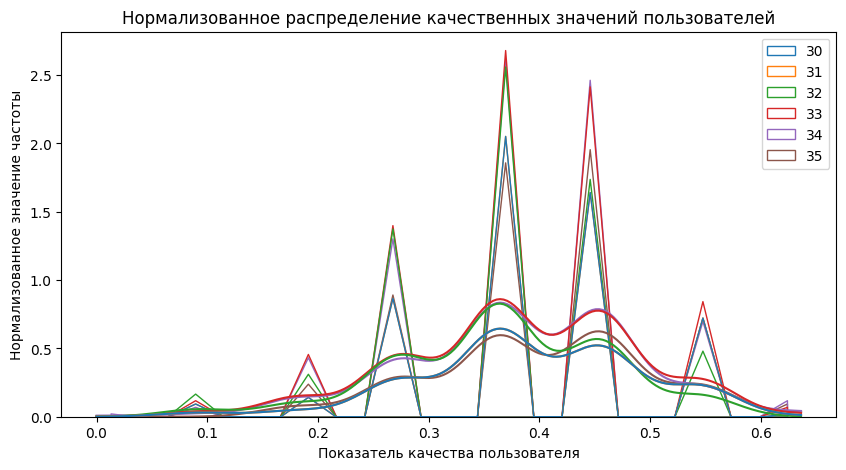

In [41]:
# построим графиг
plt.figure(figsize=(10,5))
sns.histplot(data=p,kde = True,legend =(True),bins = 25,element="poly",linewidth=1,
    stat='density',common_norm=True,alpha = 0.00)
plt.title('Нормализованное распределение качественных значений пользователей')
plt.xlabel('Показатель качества пользователя')
plt.yticks(fontsize=10)
plt.ylabel('Нормализованное значение частоты')
plt.yticks(rotation=0)
plt.show()

* **На графике можно заметить что голосующие группируются по одному принципу на всех выборах, форма распределения лишь незначительно изменяется на определенных участках. Это может говорить об относительной однородности качества голосующих на каждых выборах**

# Проведем кластерный анализ профилей методом KMeans для выявления закономерностей в изменении электорального поведения

In [42]:
# заполним пропуски 
p = p.fillna(-1)

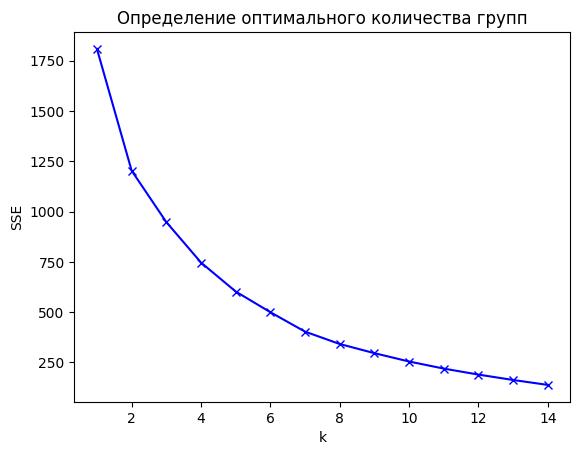

In [43]:
# определим оптимальное количество групп
Sum_of_squared_distances =[]
K = range(1,15)
for k in K:
    km =KMeans(n_clusters =k)
    km =km.fit(p)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Определение оптимального количества групп')
plt.show()

In [44]:
# подставим оптимальное значение для обучения модели

kmeans = KMeans(n_clusters=5).fit(p)

In [45]:
# зададим группы значением цвета для cluster map 
row_colors =  pd.DataFrame( kmeans.labels_ )
row_colors['kmeans_group'] = kmeans.labels_

lut1 = dict(zip(set(kmeans.labels_), ['#ED2323','#60FD00','#6A5ACD','#000000','#8B4513']))
row_colors = row_colors['kmeans_group'].map(lut1)
row_colors.index = p.index
row_colors.head()


X0stark69        #ED2323
Mike like0708    #ED2323
Brateevsky       #6A5ACD
Forgottenous     #ED2323
Swarrel          #6A5ACD
Name: kmeans_group, dtype: object

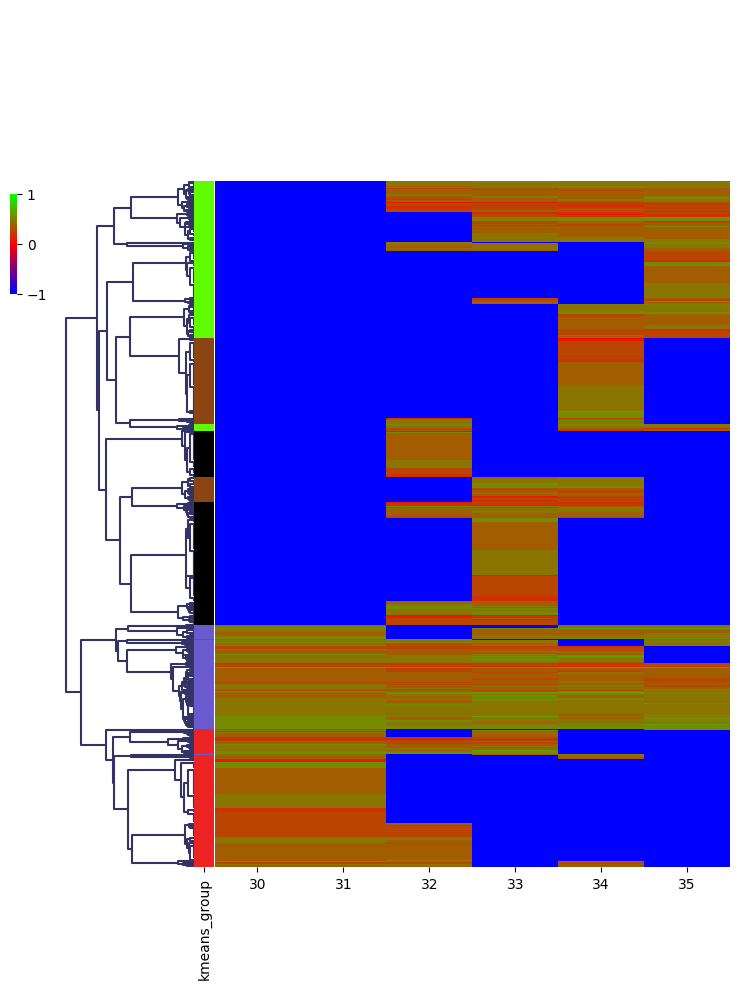

In [46]:
# Просторим тепловую карту с кластерами
h = sns.clustermap(p,annot=False,cbar_pos=(-0.05, .7, .01, .1), yticklabels=False, xticklabels=True,figsize=(7,10),tree_kws=dict(linewidths=1.5, colors=(0.2, 0.2, 0.4)),lw=0.0,
                   row_colors= row_colors, method="average",col_cluster=False,cmap="brg",vmin=-1, vmax=1)
plt.show()

* **Синим закрасили пропуски. На карте видно, что основная часть пользователей принимает участие в 1 или 2 выборах, однако красная группа приняла участие во всех выборах. Также у этой группы можем заметить более выраженную изменчивость показателей, а так как показатели активности статичны в нашем случае, то изменения происходят в их электоральном поведении. Выделим эту группу для дальнейшего анализа.**

# Анализ группы, принявшей участие во всех выборах

In [47]:
# проведем вычисления
p = pd.DataFrame()
for i in list(df.n.unique()):
    history, result, winners, active, voters, losers, voters_profile, vot_cand  = voters_itog_wiki(i,df)
    tmp = voters_profile.mean(axis=1)
    tmp.columns = i
    p = pd.concat([p, tmp], ignore_index=True, sort=False,axis=1)
p.columns = list(df.n.unique())    



# Выделим данные 
old =  p.loc[p.isna().any(axis = 1)==False].index

# Построим таблицу суммы голосов
old = df.query("voter in @old").pivot_table(index='voter',columns='candidate',values= 'vote',aggfunc='sum').fillna(0)
display(old.head())
print(f"Проголосоваго во всех выборах: {len(old.index)}")

candidate,Abiyoyo,Adamant.pwn,Ailbeve,Alexander Roumega,AndreiK,AndyHomba,AndyVolykhov,Arsenal.UC,Bapak Alex,Biathlon,...,Wild lionet,Znatok251,Всеслав Чародей,Гоголь М,Евгений Юрьев,Кронас,Ле Лой,Роман Беккер,Юлия 70,Юрий Владимирович Л.
voter,,,,,,,,,,,,,,,,,,,,,
Adamant.pwn,0.0,0.0,-1.0,-2.0,-2.0,-1.0,2.0,-1.0,0.0,0.0,...,0.0,0.0,2.0,-1.0,0.0,1.0,2.0,0.0,0.0,2.0
Adavyd,0.0,-4.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,-1.0,...,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,1.0,2.0
Alex fand,1.0,4.0,0.0,-1.0,-2.0,1.0,2.0,-4.0,0.0,2.0,...,0.0,0.0,-1.0,0.0,0.0,-1.0,2.0,0.0,-1.0,2.0
Altes,1.0,0.0,0.0,-4.0,0.0,0.0,2.0,-4.0,0.0,2.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,2.0,-1.0,0.0,2.0
AndyVolykhov,-1.0,4.0,0.0,-5.0,-2.0,-1.0,0.0,-5.0,1.0,2.0,...,-1.0,0.0,-1.0,-1.0,0.0,-1.0,2.0,1.0,1.0,2.0


Проголосоваго во всех выборах: 63


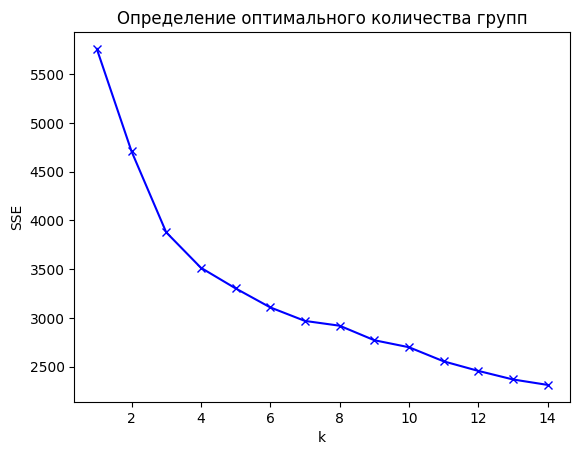

In [48]:
# подберем оптимальное значение групп
Sum_of_squared_distances =[]
K = range(1,15)
for k in K:
    km =KMeans(n_clusters =k)
    km =km.fit(old)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Определение оптимального количества групп')
plt.show()

In [49]:
# в данном случае 3 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4).fit(old)

In [50]:
# зададим группы значением цвета для cluster map 
row_colors =  pd.DataFrame( kmeans.labels_ )
row_colors['kmeans_group'] = kmeans.labels_

lut1 = dict(zip(set(kmeans.labels_), ['#ED2323','#60FD00','#6A5ACD','#000000']))
row_colors = row_colors['kmeans_group'].map(lut1)
row_colors.index = old.index
row_colors.head()

voter
Adamant.pwn     #ED2323
Adavyd          #ED2323
Alex fand       #60FD00
Altes           #60FD00
AndyVolykhov    #60FD00
Name: kmeans_group, dtype: object

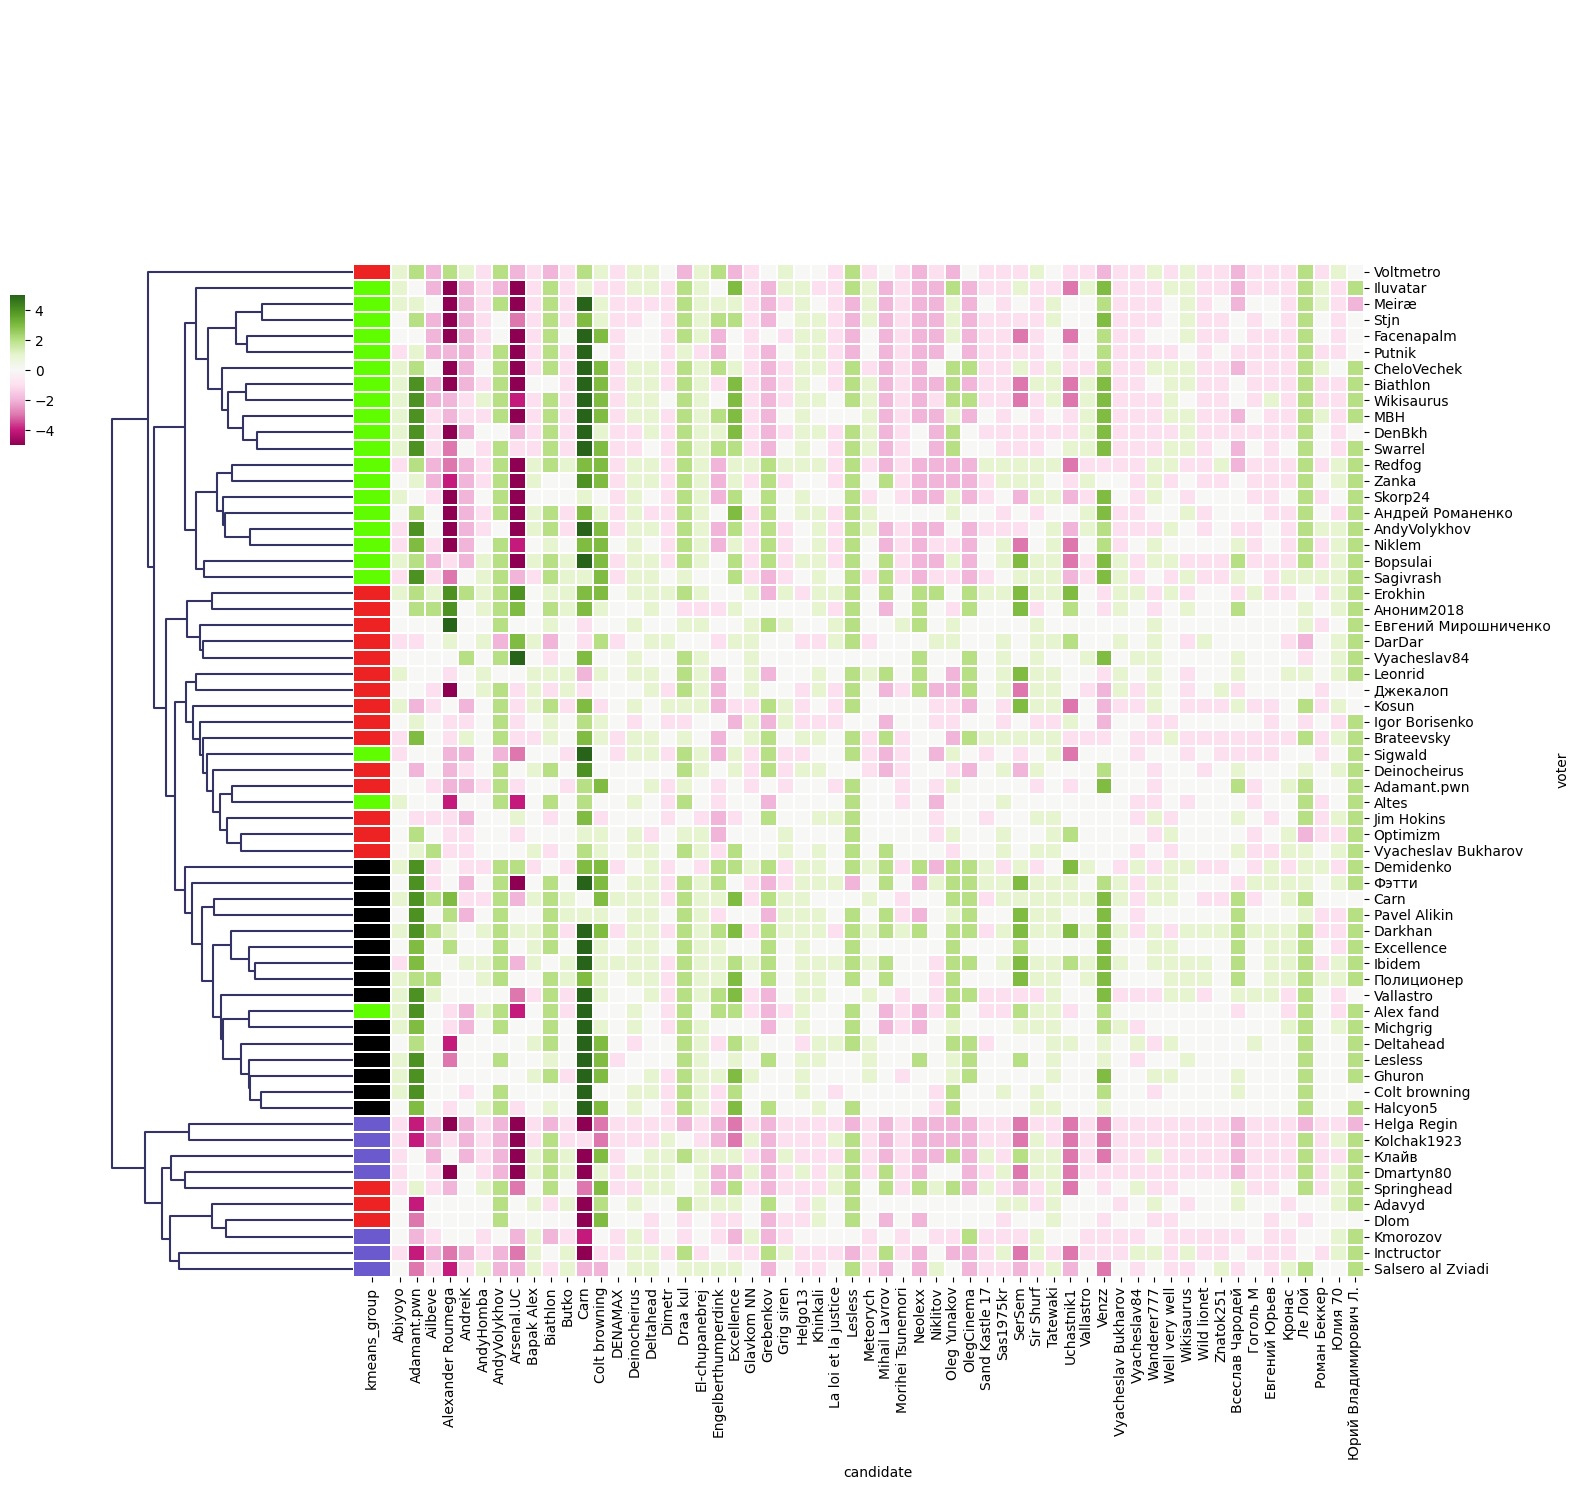

In [51]:
# Построим график
h = sns.clustermap(old,annot=False,cbar_pos=(-0.05, .7, .01, .1), yticklabels=True, xticklabels=True,figsize=(15,15),\
                   tree_kws=dict(linewidths=1.5, colors=(0.2, 0.2, 0.4)),lw=0.011,
                   row_colors= row_colors, method="average",col_cluster=False,cmap="PiYG")



plt.show()

* **По графику видно, что пользователи довольно хорошо разделились на 4 группы с подобным образом голосования. Верхняя группа имеет тенденцию к систематическому голосованию за одних кандидатов и против других, такой выбор был сделан как минимум в 4 из 6 случаев. Также можно заметить что нижняя группа имеет больше отрицательных голосов и особо активно голосует против выбора верхней группы.**

# Проведем сравнительный анализ изменений состава голосующих, а также их электорального поведения для каждых выборов

* **Воспользовавшись нашей функцией, построим графики для сравнения всех выборов по составу их участников, а также для сравнения истории голосования в подозрительных выборах**

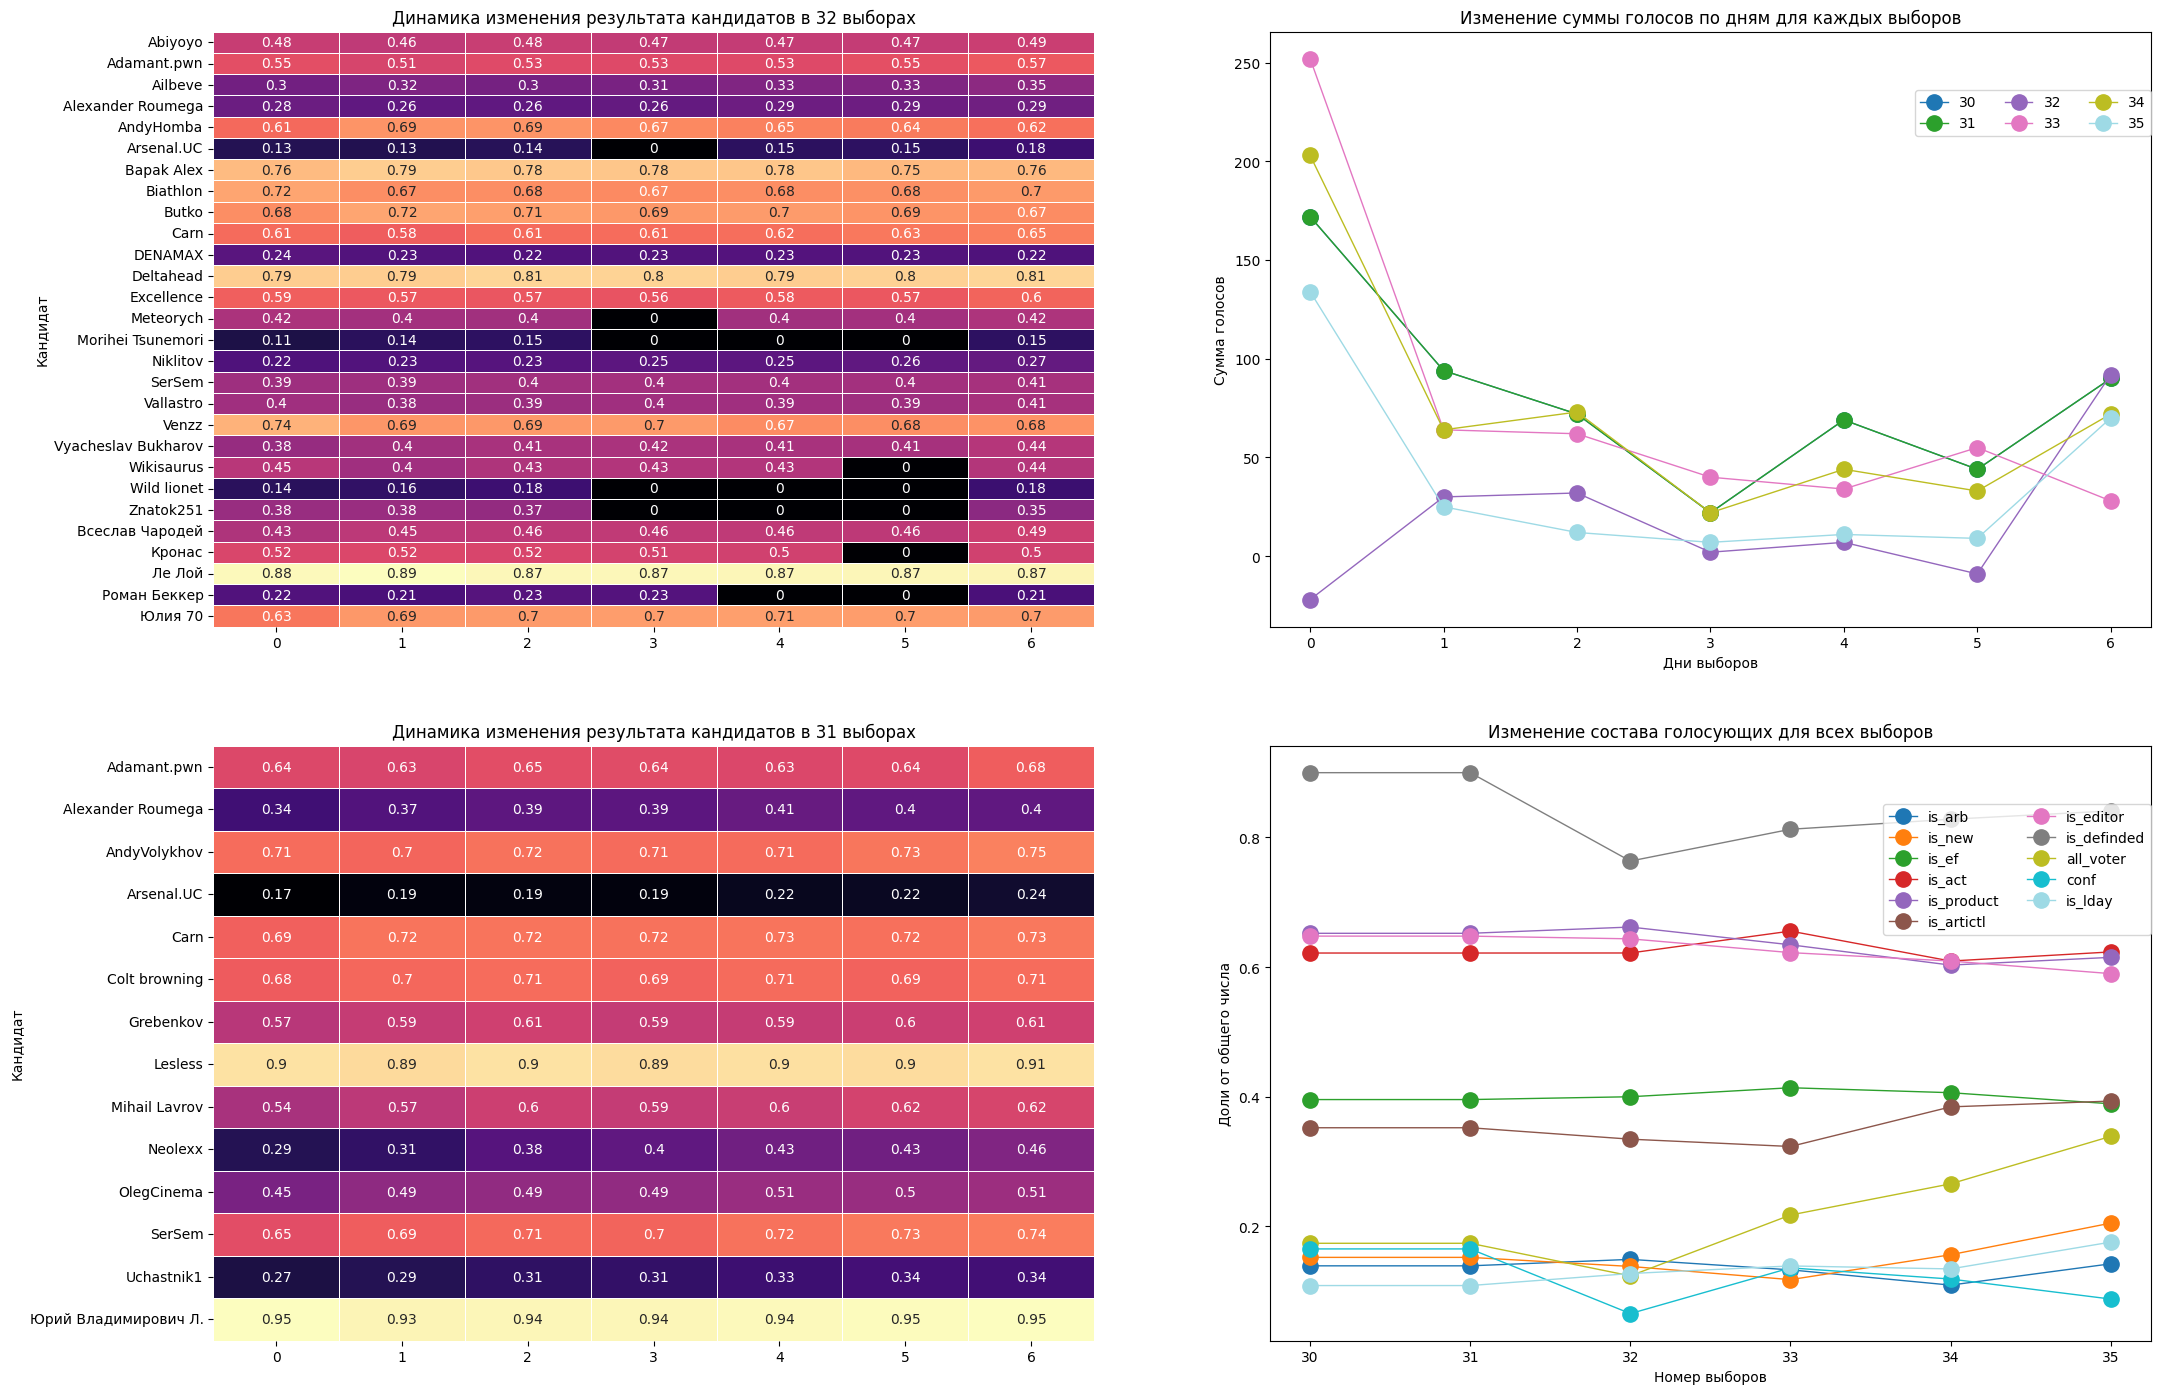

In [52]:
plt.figure(figsize=(25, 17))

# sum_votes by day of every election
ax4 = plt.subplot(2, 2, 2)
din = pd.DataFrame()
for i in list(df.n.unique()):
    history, result, winners, active, voters, losers, voters_profile, vot_cand  = voters_itog_wiki(i,df)
    tmp = active.reset_index(drop=True)
    tmp.columns = i
    din = pd.concat([din, tmp], ignore_index=True, sort=False,axis=1)

    
din.columns = list(df.n.unique())    
din.plot(linewidth=1,cmap='tab20',ax=ax4,marker='.',markersize=22)
plt.legend(bbox_to_anchor=(0., 0.8, 1., .102), loc='best',
           ncol=3, borderaxespad=0.)
plt.title('Изменение суммы голосов по дням для каждых выборов')
plt.xlabel('Дни выборов')
plt.yticks(fontsize=10)
plt.ylabel('Сумма голосов')
plt.yticks(rotation=0)


# Plotting changing the composition of voters
ax2 = plt.subplot(2,2,4)
# didis
v = pd.DataFrame()
for i in list(df.n.unique()):
    history, result, winners, active, voters, losers, voters_profile, vot_cand  = voters_itog_wiki(i,df)
    tmp = voters_profile.mean()
    tmp.columns = i
    v = pd.concat([v, tmp], ignore_index=True, sort=False,axis=1)
v.columns = list(df.n.unique())    
v.T.plot(linewidth=1,cmap='tab20',ax = ax2,marker='.',markersize=22)
plt.legend(bbox_to_anchor=(0., 0.8, 1., .102), loc='best',
           ncol=2, borderaxespad=0.,title='')
plt.title('Изменение состава голосующих для всех выборов')
plt.xlabel('Номер выборов')
plt.yticks(fontsize=10)
plt.ylabel('Доли от общего числа')
plt.yticks(rotation=0)



# Plotting history voted
ax3 = plt.subplot(2,2,3)
history, result, winners, active, voters, losers, voters_profile, vot_cand  = voters_itog_wiki(31,df)

sns.heatmap(history,cbar=False,linewidth=.5,annot=True,xticklabels='0123456', yticklabels='auto',
            cmap='magma',ax = ax3)
plt.title('Динамика изменения результата кандидатов в 31 выборах')
plt.xlabel('')
plt.yticks(fontsize=10)
plt.ylabel('Кандидат')
plt.yticks(rotation=0)


# Plotting history voted
ax1 = plt.subplot(2,2,1)
history, result, winners, active, voters, losers, voters_profile, vot_cand  = voters_itog_wiki(32,df)

sns.heatmap(history,cbar=False,linewidth=.5,annot=True,xticklabels='0123456', yticklabels='auto',
            cmap='magma',ax = ax1)
plt.title('Динамика изменения результата кандидатов в 32 выборах')
plt.xlabel('')
#plt.yticks([])
plt.yticks(fontsize=10)
plt.ylabel('Кандидат')
plt.yticks(rotation=0)

plt.show()

* **Применив функцию, мы построили необходимые графики. При сравнительном анализе выборов на линейных графиках справа мы можем заметить, что состав голосующих во всех выборах относительно стабилен по выявленным признакам относительно их активности, однако на 32 выборах заметна просадка по 3 показателям, характеризующим электоральное поведение. По каким-то причинам доли определившихся, конформистов и людей отдающих все голоса существенно снизилась. Также на графике изменения суммы голосов выделяется наличие протестного голосования в первый день и резкое увеличение положительных голосов в последний, что выбивается из тенденции во время других выборов. Далее мы можем заметить тенденцию на увеличение людей, которые отдают все свои голоса после 32 выборов. Сравним аномальные 32 выборы с соседними 31 без аномалий, используя таблицы истории изменения доли положительных голосов. После их анализа можно заметить большее число кандидатов и больший разброс результатов в 32, общие тенденции на незначительное изменение результатов 1 и последнего дня голосования в большею сторону сохраняются, однако в 32 можно обратить внимание на понижение результата кандидата под ником "VenZZ", что может быть связано с голосованием против него после первого дня. Также следует отметить, что уровень определившихся участников довольно высок и находится на уровне порядка 80%, тогда как конформистов и голосующих в последний день находится между 15% и 20%. Для определения причины изменения поведения пользователей попробуем выделить их из общей выборки, для этого выделим голосующих на пересечении этих множеств ведь понижение доли по 3 показателям одновременно может говорить, что люди изменившие свое поведение ушли в противоположное множество** 

## Кластерный анализ методом KMeans выборки потенциальных виновников электоральных аномалий во время 32 выборов

In [53]:
# применим функцию 
history, result, winners, active, voters, losers, voters_profile, vot_cand  = voters_itog_wiki(32,df)

# выделим пользователей на пересечении множеств с аномальными изменениями
voters_profile = voters_profile.loc[(voters_profile['is_definded']==0)&(voters_profile['conf']==0)&(voters_profile['all_voter']==0)]

In [54]:
# добавим информацию о голосавании 
al = pd.concat([voters_profile,vot_cand],ignore_index=False,sort=False,join ='inner',axis=1)


display(al.head())
print(f"Потенциальные виновники элокторальных аномалий: {len(al.index)}")

,is_arb,is_new,is_ef,is_act,is_product,is_artictl,is_editor,is_definded,all_voter,conf,...,Venzz,Vyacheslav Bukharov,Wikisaurus,Wild lionet,Znatok251,Всеслав Чародей,Кронас,Ле Лой,Роман Беккер,Юлия 70
voter,,,,,,,,,,,,,,,,,,,,,
Sneeuwschaap,0,0,0,1,1,1,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Skorp24,0,0,0,1,1,0,1,0,0,0,...,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
Kmorozov,0,0,0,1,1,0,1,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0
MBH,0,0,0,1,1,0,1,0,0,0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
Meteorych,0,0,0,0,0,0,1,0,0,0,...,1.0,-1.0,1.0,-1.0,1.0,1.0,0.0,1.0,1.0,-1.0


Потенциальные виновники элокторальных аномалий: 58


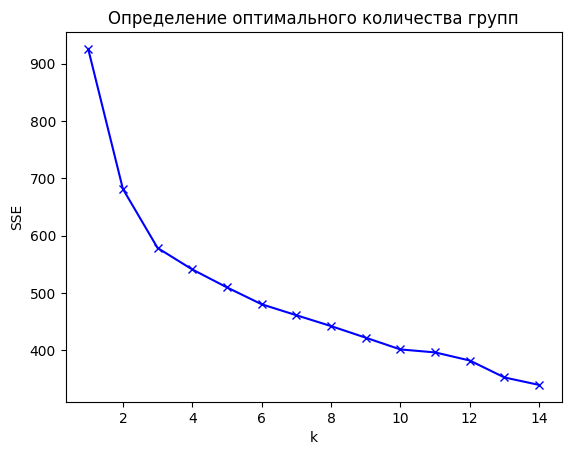

In [55]:
# подберем оптимальное значение групп
Sum_of_squared_distances =[]
K = range(1,15)
for k in K:
    km =KMeans(n_clusters =k)
    km =km.fit(al)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Определение оптимального количества групп')
plt.show()

In [56]:
# в нашем случае 3 группы, обучим модель
kmeans = KMeans(n_clusters=3).fit(al)

In [57]:
# сформируем ряд цвета групп 
row_colors =  pd.DataFrame( kmeans.labels_ )
row_colors['kmeans_group'] = kmeans.labels_

lut1 = dict(zip(set(kmeans.labels_), ['#ED2323','#60FD00','#FFFF00','#00FFFF']))
row_colors = row_colors['kmeans_group'].map(lut1)
row_colors.index = al.index
row_colors.head()


voter
Sneeuwschaap    #ED2323
Skorp24         #FFFF00
Kmorozov        #60FD00
MBH             #ED2323
Meteorych       #ED2323
Name: kmeans_group, dtype: object

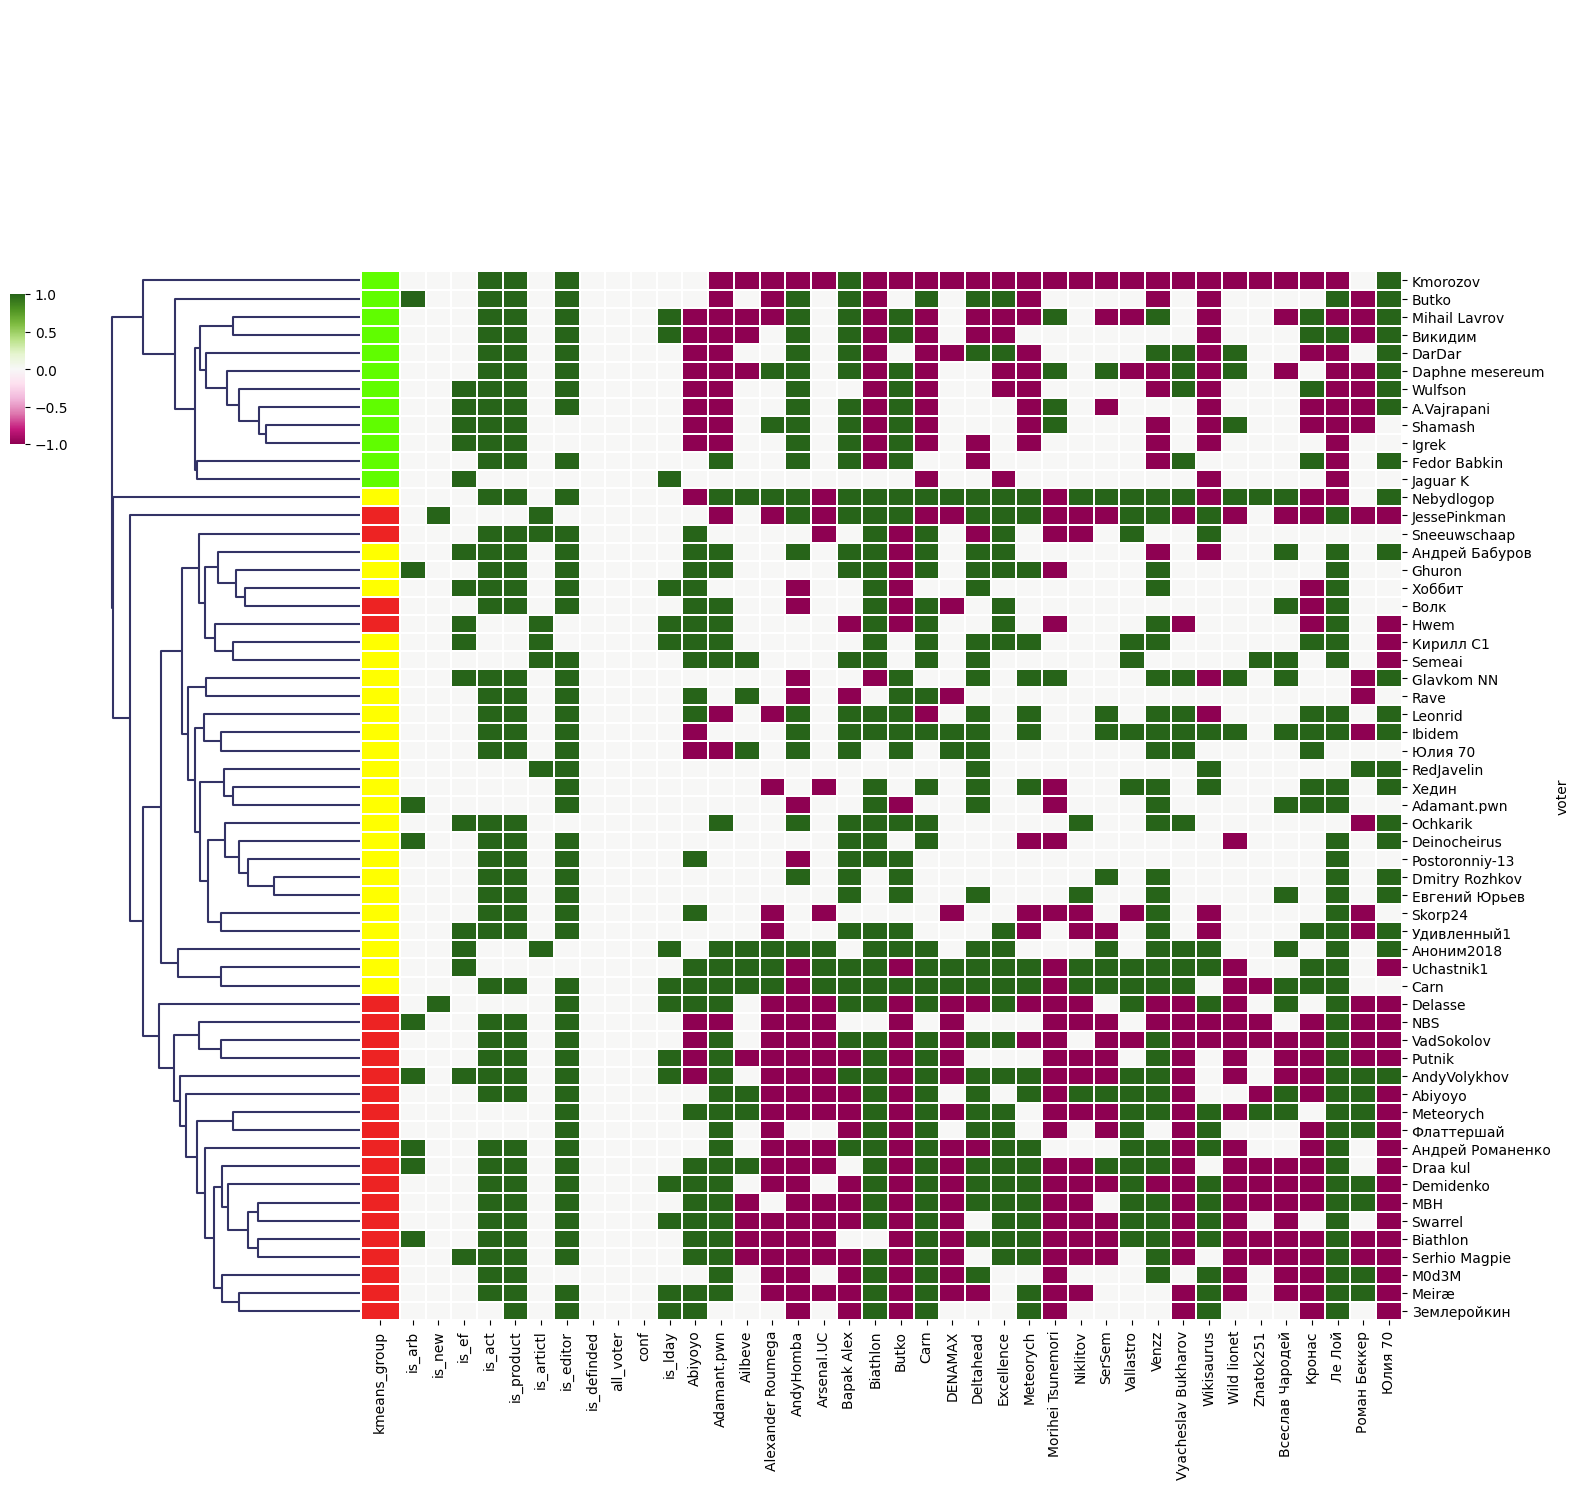

In [58]:
# построим график
h = sns.clustermap(al,annot=False,cbar_pos=(-0.05, .7, .01, .1), yticklabels=True, xticklabels=True,figsize=(15,15),tree_kws=dict(linewidths=1.5, colors=(0.2, 0.2, 0.4)),lw=0.011,
                   row_colors= row_colors, method="average",col_cluster=False,cmap="PiYG",vmin=-1, vmax=1)

plt.show()

* **На графике можно заметить что в список попало большое количество активных и продуктивных людей которые в логах имеют основную часть записей о правках. Они отлично забились на з группы с подобным распределением голосов по кандидатам, причем можно заметить что красная и зеленая группы голосуют за одних и против других в противоположном значении.**

# Вывод по итогам исследования:
* **Можно заметить что голосующие группируются по одному принципу на всех выборах, форма распределения лишь незначительно изменяется на определенных участках. Это может говорить об относительной однородности качества голосующих на каждых выборах**
* **Основная часть пользователей принимает участие в 1 или 2 выборах, однако одна группа приняла участие во всех выборах. Также у этой группы можем заметить более выраженную изменчивость показателей, а так как показатели активности статичны в нашем случае, то изменения происходят в их электоральном поведении.**
* **Пользователи, участвовавшие во всех выборах, довольно хорошо разделились на 4 группы с подобным образом голосования. Верхняя группа имеет тенденцию к систематическому голосованию за одних кандидатов и против других, такой выбор был сделан как минимум в 4 из 6 случаев. Также можно заметить что нижняя группа имеет больше отрицательных голосов и особо активно голосует против выбора верхней группы.**
* **При сравнительном анализе выборов мы можем заметить, что состав голосующих во всех выборах относительно стабилен по выявленным признакам относительно их активности, однако на 32 выборах заметна просадка по 3 показателям, характеризующим электоральное поведение. По каким-то причинам доли определившихся, конформистов и людей отдающих все голоса существенно снизилась. Также на графике изменения суммы голосов выделяется наличие протестного голосования в первый день и резкое увеличение положительных голосов в последний, что выбивается из тенденции во время других выборов. Далее мы можем заметить тенденцию на увеличение людей, которые отдают все свои голоса после 32 выборов. Сравнив аномальные 32 выборы с соседними 31 без аномалий, используя таблицы истории изменения доли положительных голосов можно заметить большее число кандидатов и больший разброс результатов в 32, общие тенденции на незначительное изменение результатов 1 и последнего дня голосования в большею сторону сохраняются, однако в 32 можно обратить внимание на понижение результата кандидата под ником "VenZZ", что может быть связано с голосованием против него после первого дня. Также следует отметить, что уровень определившихся участников довольно высок и находится на уровне порядка 80%, тогда как конформистов и голосующих в последний день находится между 15% и 20%**
* **В список потенциальных виновников аномалий на 32 выборах попало большое количество активных и продуктивных людей которые в логах имеют основную часть записей о правках. Они отлично забились на з группы с подобным распределением голосов по кандидатам, причем можно заметить что красная и зеленая группы голосуют за одних и против других в противоположном значении.**
## Общий комментарий: 
* **Качество и эффективность пользователей напрямую зависят от их опыта**
* **Более активные пользователи менее продуктивны и эффективны**
* **Открытые выборы подвержены манипуляциям посредствам сговора**
* **Обнаружено аномальное электоральное поведение пользователей на 32 выборах**